In [1]:
data = '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/raw_kaggle/Speeches.xlsx'

In [2]:
import math
import os

import jiwer
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import librosa

import torchaudio

# Data loading

In [3]:
BATCH_SIZE = 4

In [4]:
df = pd.read_excel(data)
df.head()

,Число,Русская речь
0,1,Как пройти до корпуса?
1,2,Где взять направление?
2,3,Бумага есть
3,4,анальгин
4,5,вата


In [5]:
import subprocess
def get_audio_path(i: int) -> str | bool:
    candidates = [
        '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/Борис. Фразы(0-100)/{}.m4a'.format(i),
        '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/Борис. Фразы(101-238/{}.m4a'.format(i),
        '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/Борис. Фразы(239-399)/{}.m4a'.format(i),
    ]
    for path in candidates:
        if os.path.exists(path):
            if not os.path.exists(path+'.wav'):
                subprocess.run(['ffmpeg', '-i', path, path+'.wav'])
            return path+'.wav'
    return False
def get_audio(path: str):
    return torch.Tensor(librosa.load(path, sr=16000)[0]).view(1,-1)

In [6]:
get_audio_path(4)

False

In [7]:
missed_files = []
for i in df.iterrows():
    num = i[0]
    if not get_audio_path(num):
        missed_files.append(num)
# missed_files

In [8]:
len(missed_files)/len(df)

0.8025

In [9]:
missed_files[0]

0

In [10]:
batch_to_loss = {}

In [11]:

for i in missed_files:
    df = df[df['Число']!=i]


In [12]:
df.reset_index(inplace=True, drop=True)

In [13]:
df.head()

,Число,Русская речь
0,5,вата
1,7,Где преподаватель?
2,19,Столовая прямо по коридору
3,23,Лабиринт
4,29,Ограничения


In [14]:
librosa.load(get_audio_path(23))

(array([-8.8853506e-07,  1.1100863e-06, -1.5497349e-06, ...,
         6.3932021e-05,  6.5215681e-07, -2.0521853e-05], dtype=float32),
 22050)

In [25]:
class SpeechDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, start=0, end=2000):
        self.df = df
        self.start=start
        self.end=end
    def __len__(self):
        return self.end - self.start
    def __getitem__(self, idx: int):
        new_idx = idx+self.start
        return idx, get_audio(get_audio_path(self.df["Число"][new_idx])), self.df["Русская речь"][new_idx]
abc = '?абвгдеёжзийклмнопрстуфхшщчцьыъэюя'
def collate_spl(batch):
    wfs, lbls, idxs = [], [], []
    for k, i,j in batch:
        wfs.append(i)
        lbls.append(j)
        idxs.append(k)
    
    return  idxs, wfs, lbls
def clear_str(s): return ''.join(i for i in s.lower() if i in abc)

In [26]:
def str_to_tensor(strs: list[str])->tuple[torch.Tensor, torch.Tensor]:
    lengths = torch.zeros((len(strs),), dtype=int)
    result = []
    for idx, i in enumerate(strs):
        result.append([abc.index(j) for j in i.lower() if j in abc[1:]])
        lengths[idx] = len(result[-1])
    res_tensor = torch.zeros((len(strs), lengths.max().item()))
    for idx0, i in enumerate(result):
        for idx1, c in enumerate(i):
            res_tensor[idx0, idx1] = c
    return res_tensor, lengths

In [27]:
train_transforms = torchaudio.transforms.MelSpectrogram(
    n_mels=128
    )

/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


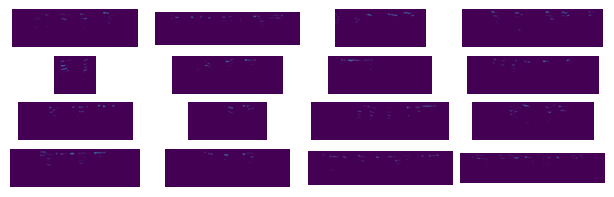

In [28]:
fig, axs = plt.subplots(4,4, layout='compressed')
k = 0
for i in range(4):
    for j in range(4):
        while True:
            p = get_audio_path(k)
            k += 1
            if   p:
                break
        wf = get_audio(p)
        axs[i,j].set_axis_off()
        axs[j,i].imshow(train_transforms(wf)[0])

In [29]:
len(df)

396

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
train_df = SpeechDataset(df, 0, 300)
val_df = SpeechDataset(df, 300, 395)

In [32]:
def padded_stack(list_of_tensors, maxlen=16):
    maxlen = max(x.shape[1] for x in list_of_tensors)
    output = torch.zeros((len(list_of_tensors), maxlen, list_of_tensors[0].shape[-1]))
    for i, t in enumerate(list_of_tensors):
        output[i, :min(maxlen, t.shape[1]), :] = t[0,:maxlen, :]
    return output

In [96]:
class WorstFirstSampler:
    def __init__(self, ds_len: int, batch_size: int):
        self.ds_len = ds_len
        self.batch_size = batch_size
        self.losses = [float('inf') for i in range(ds_len)]
    
    def __len__(self):
        return self.ds_len//self.batch_size

    def __iter__(self):
        for _ in range(self.ds_len//self.batch_size):
            r=[]
            for i in range(self.batch_size):
                r.append(self.losses.index(max(self.losses)))
                self.losses[r[-1]] = float('-inf')
            yield r
    def update(self, ixs, new_loss):
        for i in ixs:
            self.losses[i] = new_loss

In [97]:
train_sampler = WorstFirstSampler(len(train_df), BATCH_SIZE)
train_dataloader = DataLoader(train_df, collate_fn=collate_spl,batch_sampler=train_sampler)
val_dataloader = DataLoader(val_df, batch_size=BATCH_SIZE, collate_fn=collate_spl, shuffle=True)

In [98]:
# import random
# for i in train_dataloader:
#     print(i[0])
#     train_sampler.update(i[0], random.random())

In [99]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, hidden_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(hidden_channels, in_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(hidden_channels)
        self.batchnorm2 = nn.BatchNorm1d(in_channels)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out + x
                


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.Dropout1d(0.1),
            nn.MaxPool1d(2),
            ResidualBlock(64, 128, 3, 1, 1),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.Dropout1d(0.1),
            nn.MaxPool1d(2),
        )
        self.rnn = nn.GRU(input_size=32, 
                    hidden_size=32, 
                    num_layers=1, 
                    batch_first=True, 
                    bidirectional=True)
        
        self.fc = nn.Linear(64, 34)
        self.act = nn.LogSoftmax(-1)
    
    def forward(self, X):
        # X: batch x 128 x len
        # X = X[:,:,::4] 
        X = self.cnn(X)
        X = X.permute(0,2,1)
        X, _ = self.rnn(X)
        X = self.fc(X)
        X = self.act(X)
        return X

model=Model().to(device)

In [100]:
print('params: ', sum(i.nelement() for i in model.parameters()))

params:  95618


In [101]:
loss = nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters())

In [102]:
def get_y_lengths(y):
    return torch.ones(y.shape[0], dtype=int)*y.shape[-2]

In [103]:
import tqdm

In [104]:
def train_step():
    history = [0]
    model.train()
    i=0
    r=[]
    target = []
    optimizer.zero_grad()
    for batch in tqdm.tqdm(train_dataloader):
        i+=1
        spectrograms = [train_transforms(i).permute(0,2,1) for i in batch[1]]
        spectrograms = padded_stack(spectrograms).permute(0,2,1) # baatch x features x len
        target_t, target_len = str_to_tensor(batch[2])
        target.append([clear_str(i) for i in batch[2]])
        output = model(spectrograms.to(device))
        lv = loss(output.permute(1,0,2), target_t.to(device), get_y_lengths(output), target_len)
        lve= torch.exp(lv).item()
        train_sampler.update(batch[0], lve)
        history.append(lve)
        r.append(output.argmax(-1))
        
        lv.backward()
        if i%1==0:
            optimizer.step()
            optimizer.zero_grad()
    return history, r, target
# hist, r, target = train_step()

In [105]:
hist, r, target = train_step()

100%|██████████| 75/75 [00:02<00:00, 27.90it/s]


In [106]:
def val_step():
    history = [0]
    model.eval()
    i=0
    r=[]
    target = []
    for batch in tqdm.tqdm(val_dataloader):
        i+=1
        spectrograms = [train_transforms(i).permute(0,2,1) for i in batch[1]]
        spectrograms = padded_stack(spectrograms).permute(0,2,1) # baatch x features x len
        target.append([clear_str(i) for i in batch[2]])
        target_t, target_len = str_to_tensor(batch[2])
        output = model(spectrograms.to(device))
        lv = loss(output.permute(1,0,2), target_t.to(device), get_y_lengths(output), target_len)
        lve= torch.exp(lv).item()
        history.append(lve)
        r.append(output.argmax(-1))
        
    return history, r, target
# hist, r, arget = val_step()

In [119]:
history, r, target=val_step()

100%|██████████| 24/24 [00:01<00:00, 20.17it/s]


In [108]:
def show_batch(r, target):
    am = r
    for i in range(min(am.shape[0], len(target))):
        p=0
        s=''
        for j in range(am.shape[1]):
            if (c:=am[i,j]) not in [0, p]:
                s+=abc[c]
                p=c
        
        print(s, '/', target[i], 'cer: ', jiwer.cer(s, target[i]) if len(s)>0 else -1)

In [109]:
r[-1].shape

torch.Size([3, 243])

In [120]:
show_batch(r[-1], target[-1])

пойиаойнякыйтезао / эффективностьвработезависитотконцентрации cer:  2.0
сицве / таинственнаямгла cer:  2.6
паыеом / работаюповыходнымдням cer:  2.8333333333333335


In [111]:
def to_str(r):
    res=[]
    for i in r:
        res.append([])
        for bn in i:
            res[-1].append(''.join(abc[j] for j in bn))
    return res
def avg_cer(r, target):
    s=0
    c=0
    for i, j in zip(to_str(r), target):
        try:
            s+=jiwer.cer(i, j)
            c +=1
        except:
            continue
    return s/c if c>0 else 1
# [clear_str(i) for i in batch[1]]

In [112]:
train_loss=[]
train_cer=[]
val_loss=[]
val_cer=[]


In [121]:

for epoch in range(300):
    print("epoch", epoch)
    hist, r, target = train_step()
    tl = sum(hist)/len(hist)
    train_loss.append(tl)
    print("train loss: ", tl)
    show_batch(r[-1], target[-1])
    show_batch(r[-2], target[-2])
    tc = avg_cer(r, target)
    train_cer.append(tc)
    print("train cer:", tc)
    hist, r, target = val_step()
    vl = sum(hist)/len(hist)
    print("val loss: ", vl)
    val_loss.append(vl)
    show_batch(r[-1], target[-1])
    show_batch(r[-2], target[-2])
    vc = avg_cer(r, target)
    val_cer.append(avg_cer(r, target))
    print("val cer:", vc)

epoch 0


100%|██████████| 75/75 [00:02<00:00, 25.52it/s]


train loss:  24.663781051573
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.9317429860838297


100%|██████████| 24/24 [00:01<00:00, 22.48it/s]


val loss:  1479.533116455078
иемкыйоби / белыйсвет cer:  0.7777777777777778
мнемжнвовроштра / жизньэтоточтослучаетсястобойпокатызанятдругимипланами cer:  3.066666666666667
вейквганшвнмеи / будешьнаработедопоздна? cer:  1.5
всвонсваеднойвноей / незабываемоепутешествиенаморе cer:  1.2777777777777777
ыйктьймчл / какойфильмсмотримсегодня? cer:  2.4444444444444446
аскаенаойеае / рассветнавершинегоры cer:  1.1666666666666667
кгадаерветелу / отстаньтеонзайметсясвязьюкогдаприедет cer:  2.4615384615384617
val cer: 0.9776154728759083
epoch 1


100%|██████████| 75/75 [00:03<00:00, 23.91it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:01<00:00, 21.98it/s]


val loss:  1629.896944580078
маьвоисиеы / естьлиновостиизшколы? cer:  1.6
изаео / привезешьмнеизмагазинапарубутылокводыпожалуйста? cer:  8.8
кыйореуб / написатьписьмодругу cer:  2.125
пвовлвлосроеоеоевенонаспнс / извиниянеуслышалтебяможешьповторить? cer:  1.1538461538461537
теветереле / мненужендополнительныйлистбумаги cer:  2.7
чдвыйяосрчеидо / купитьлекарстваотнасморка cer:  1.6428571428571428
иезаутнчныйетей / садисьуокнавидотличный cer:  1.2
val cer: 0.9779995453752001
epoch 2


100%|██████████| 75/75 [00:02<00:00, 26.19it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.90it/s]


val loss:  1692.345234375
кгадаервел / отстаньтеонзайметсясвязьюкогдаприедет cer:  3.2
ыйкуйдб / золотаясередина cer:  2.0
хродывтргу / горькийшоколад cer:  1.3
малвыдуио / этобылонеожиданноепереживаниеидляменя cer:  3.7777777777777777
лне / будьтесегоднялучшечемвчера cer:  8.0
мнемжнвевовщроштра / жизньэтоточтослучаетсястобойпокатызанятдругимипланами cer:  2.5555555555555554
изстниа / большенехочуестьмясо cer:  2.5714285714285716
val cer: 0.9786151194831839
epoch 3


100%|██████████| 75/75 [00:02<00:00, 25.90it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.94it/s]


val loss:  1660.1343615722656
сар / зеленыйлуг cer:  3.3333333333333335
теветереле / мненужендополнительныйлистбумаги cer:  2.7
кыдаы / кротоваянастойка cer:  2.8
ысюйж / такоечувствобудтожизньпроходитмимо cer:  6.4
момкиаионойосев / принимайизменениякакшанснановыевозможности cer:  2.2666666666666666
книйтмд / крепкийзамок cer:  1.1428571428571428
дакйтсзве / наслаждайтесьмоментом cer:  1.7777777777777777
val cer: 0.9786328580350464
epoch 4


100%|██████████| 75/75 [00:02<00:00, 26.52it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.02it/s]


val loss:  2438.8271875
грескарвманесие / всегдастарайтесьвыделятьсяизтолпы cer:  1.7333333333333334
негондиак / хлебсовкуснейшимджемом cer:  2.0
скыийцвт / таинственнаямгла cer:  1.875
чвыйяосрчеидо / купитьлекарстваотнасморка cer:  1.7692307692307692
ланаоксксксон / онизаплатятзаэтиуслугидоконцанедели cer:  2.230769230769231
кродганазаяик / тонкийлед cer:  0.8461538461538461
иотовроакре / нужнозаказатьбилеты cer:  1.4545454545454546
val cer: 0.9782548010406015
epoch 5


100%|██████████| 75/75 [00:02<00:00, 26.52it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.09it/s]


val loss:  1735.6452380371093
серщуиоскиля / какделавкочалке? cer:  1.1666666666666667
кзнвткри / приятныйзапахцветоввсаду cer:  2.625
кгадаерветелу / отстаньтеонзайметсясвязьюкогдаприедет cer:  2.4615384615384617
пчуоиоемоеу / уменясегоднямногоработы cer:  1.8181818181818181
кеповорбги / выготовысделатьзаказ? cer:  1.9
ысюйж / такоечувствобудтожизньпроходитмимо cer:  6.4
стыстросисаит / начнисначалаэтонеработает cer:  1.5384615384615385
val cer: 0.9774035811273049
epoch 6


100%|██████████| 75/75 [00:02<00:00, 25.52it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.13it/s]


val loss:  1737.841495361328
сизгорводтрыйиемб / забудемобэтоминачнемвсезаново? cer:  1.5294117647058822
кеаоствийбеьтьиывкоыйцт / тебеточнобольшенечегоделать? cer:  1.0
ивисийвкаийнзи / следуйсвоиммечтамионистанутреальностью cer:  2.357142857142857
иемкыйобжти / белыйсвет cer:  0.6363636363636364
пкмйобовтио / яобещалприйтикопределённомувремени cer:  2.6363636363636362
нобреьйидобм / тонкийслой cer:  0.75
иеаутнчныйетей / садисьуокнавидотличный cer:  1.2142857142857142
val cer: 0.978201442473054
epoch 7


100%|██████████| 75/75 [00:03<00:00, 24.92it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.27it/s]


val loss:  1494.4153125
лайегоси / горячийшоколадвхолоднуюпогоду cer:  3.125
еоеруса / фирменноеприложение cer:  2.142857142857143
шнобзядрододсвансороязлт / сделатьточтоскажешьлучшийспособуважаться cer:  1.375
пар / зеленыйлуг cer:  3.3333333333333335
хоаспкройняткныстезао / эффективностьвработезависитотконцентрации cer:  1.619047619047619
ланкаоксксксожнеый / онизаплатятзаэтиуслугидоконцанедели cer:  1.5555555555555556
етеыеоераяв / яснетерпениемждузавтрашнегодня cer:  2.090909090909091
val cer: 0.9784687731036934
epoch 8


100%|██████████| 75/75 [00:02<00:00, 26.81it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.29it/s]


val loss:  1671.1497827148437
веунистьийеленыйоеро / чайиликофе? cer:  0.85
кеповоби / выготовысделатьзаказ? cer:  2.375
систотрий / яркокрасныйцветок cer:  1.6666666666666667
зресвапристайамнопориозацнтнасго / сложностиэтовозможностьдляроста cer:  0.84375
иезаутнчныйетей / садисьуокнавидотличный cer:  1.2
негаоаноиумак / хлебсовкуснейшимджемом cer:  1.3076923076923077
кгадаерветелуя / отстаньтеонзайметсясвязьюкогдаприедет cer:  2.2857142857142856
val cer: 0.9781346324968133
epoch 9


100%|██████████| 75/75 [00:02<00:00, 25.99it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.71it/s]


val loss:  1602.8070495605468
састыьеятройик / оставьменявпокое cer:  0.7857142857142857
сымыйст / белыйпесок cer:  1.0
книатмд / крепкийзамок cer:  1.2857142857142858
пнействутевзпеняеркнигкревуоко / жизньпроходитбыстронаслаждайтесьейкаждыйдень cer:  1.3
лайегос / горячийшоколадвхолоднуюпогоду cer:  3.5714285714285716
скыийцт / таинственнаямгла cer:  2.142857142857143
вокевететрз / безопасностьнадорогах cer:  1.6363636363636365
val cer: 0.9785549959375074
epoch 10


100%|██████████| 75/75 [00:02<00:00, 26.69it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.07it/s]


val loss:  1570.934274291992
пчусоемоеу / уменясегоднямногоработы cer:  1.9
нобреьйидобм / тонкийслой cer:  0.75
ишквокнкоилв / черныйкофеназавтрак cer:  1.4166666666666667
ещиреиы / серебристыймесяц cer:  1.8571428571428572
пар / зеленыйлуг cer:  3.3333333333333335
зсосзчобтр / испечьпирог cer:  0.9
вокевебтеьойбрз / безопасностьнадорогах cer:  1.2
val cer: 0.9782839646915135
epoch 11


100%|██████████| 75/75 [00:02<00:00, 25.58it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.97it/s]


val loss:  1594.7750708007814
книатмд / крепкийзамок cer:  1.2857142857142858
иотровронамкреь / нужнозаказатьбилеты cer:  1.0666666666666667
номвбтюыйновци / темныйпереулок cer:  0.9285714285714286
кыйореуб / написатьписьмодругу cer:  2.125
сыйеотзн / ржавыйзамок cer:  1.125
поаыбетоеи / работаюповыходнымдням cer:  1.8
кекве / солнечныйлучпробилсясквозьоблака cer:  5.8
val cer: 0.9774465047299729
epoch 12


100%|██████████| 75/75 [00:02<00:00, 26.68it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.30it/s]


val loss:  1494.8832104492187
ыаелтмвожожгт / чтозаоблом? cer:  0.9230769230769231
пвовлвлосроеоеоевенонаспнс / извиниянеуслышалтебяможешьповторить? cer:  1.1538461538461537
мамойци / зарядитьсвойтелефон cer:  2.2857142857142856
чдвыйяойсрчеидо / купитьлекарстваотнасморка cer:  1.5333333333333334
иемкыйобжт / белыйсвет cer:  0.6
ховономоустиросоро / ойяпочтиопаздалнасвидание cer:  1.2222222222222223
сзгорвоводтыйиемб / забудемобэтоминачнемвсезаново? cer:  1.4705882352941178
val cer: 0.9772577078565584
epoch 13


100%|██████████| 75/75 [00:02<00:00, 26.42it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.81it/s]


val loss:  1481.7389147949218
негоаноипиак / хлебсовкуснейшимджемом cer:  1.5
мамойци / зарядитьсвойтелефон cer:  2.2857142857142856
всвонсваеднойвноей / незабываемоепутешествиенаморе cer:  1.2777777777777777
киучнойкиокнарустимн / путешествияобогащаютопытирасширяюткругозор cer:  1.8
кидиоарок / разнообразиекухонныхблюд cer:  2.3333333333333335
зсосзчобтр / испечьпирог cer:  0.9
изстиа / большенехочуестьмясо cer:  3.0
val cer: 0.97812831309809
epoch 14


100%|██████████| 75/75 [00:02<00:00, 25.89it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.10it/s]


val loss:  1604.6132983398438
пвовлвкосроеоеоевенаспда / извиниянеуслышалтебяможешьповторить? cer:  1.25
момкиаионойосев / принимайизменениякакшанснановыевозможности cer:  2.2666666666666666
иемкыйобжт / белыйсвет cer:  0.6
доит / наблюдатьзазакатом cer:  4.0
кыдатх / кротоваянастойка cer:  2.1666666666666665
невситийтереоизеорт / этакнигабылавеликолепна cer:  1.0
иезаутнчныйетей / садисьуокнавидотличный cer:  1.2
val cer: 0.9773480529009779
epoch 15


100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.04it/s]


val loss:  1741.8342065429688
дке / любовьнетребуетслов cer:  6.0
кродганазаяи / тонкийлед cer:  0.9166666666666666
иотовронамкре / нужнозаказатьбилеты cer:  1.2307692307692308
ныйтевойжордм / бытьможетстоитвызватьтакси? cer:  1.8461538461538463
мамойци / зарядитьсвойтелефон cer:  2.2857142857142856
доаонситисмийнадвавртовркроидт / этособытиепроизойдетужезавтра cer:  0.8666666666666667
еишквокоилвх / черныйкофеназавтрак cer:  1.3333333333333333
val cer: 0.9778453082640874
epoch 16


100%|██████████| 75/75 [00:03<00:00, 24.05it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.10it/s]


val loss:  1512.0851794433593
книатмд / крепкийзамок cer:  1.2857142857142858
сымныйст / белыйпесок cer:  1.0
манейстивертестиеб / уменязапланированыделадообеда cer:  1.2777777777777777
киучнойкиокнайкаустущу / путешествияобогащаютопытирасширяюткругозор cer:  1.6363636363636365
бзтьесерероеотетое / незабудьзакрытьзасобойдверь cer:  1.2222222222222223
дкене / любовьнетребуетслов cer:  3.4
пнействутевзпеняеркнигкреуоко / жизньпроходитбыстронаслаждайтесьейкаждыйдень cer:  1.3448275862068966
val cer: 0.9782624130945273
epoch 17


100%|██████████| 75/75 [00:02<00:00, 26.27it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.04it/s]


val loss:  1475.5575537109376
озавист / черныйкошмар cer:  1.7142857142857142
састыьеьятройик / оставьменявпокое cer:  0.7333333333333333
етеыеоераяв / яснетерпениемждузавтрашнегодня cer:  2.090909090909091
ценитйсьйоеды / медленныйрост cer:  0.8461538461538461
бзтьесерероеотетое / незабудьзакрытьзасобойдверь cer:  1.2222222222222223
дкене / любовьнетребуетслов cer:  3.4
вокеветыйетрз / безопасностьнадорогах cer:  1.3846153846153846
val cer: 0.9782828537708763
epoch 18


100%|██████████| 75/75 [00:03<00:00, 23.96it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.94it/s]


val loss:  1471.6172863769532
знвткри / приятныйзапахцветоввсаду cer:  3.0
пкыйчотолзсюодово / ошибкидолжныделатьсядляполученияопыта cer:  1.8235294117647058
ныйтеиевойжордму / бытьможетстоитвызватьтакси? cer:  1.4375
свамнапчежтро / живитетакчтобынебыложальпотраченноговремени cer:  2.6923076923076925
пар / зеленыйлуг cer:  3.3333333333333335
пкмйобовтьо / яобещалприйтикопределённомувремени cer:  2.6363636363636362
ысюйж / такоечувствобудтожизньпроходитмимо cer:  6.4
val cer: 0.9787313932600977
epoch 19


100%|██████████| 75/75 [00:02<00:00, 26.79it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.88it/s]


val loss:  1535.0598352050781
книйтмд / крепкийзамок cer:  1.1428571428571428
зресвапристайамнопориозацнтнасго / сложностиэтовозможностьдляроста cer:  0.84375
доит / наблюдатьзазакатом cer:  4.0
всвонсваеднойвноей / незабываемоепутешествиенаморе cer:  1.2777777777777777
кидиоарок / разнообразиекухонныхблюд cer:  2.3333333333333335
доаонситисмийнадвавртовркроидт / этособытиепроизойдетужезавтра cer:  0.8666666666666667
ыаелтмвожожги / чтозаоблом? cer:  0.9230769230769231
val cer: 0.9785202889647219
epoch 20


100%|██████████| 75/75 [00:02<00:00, 25.44it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.17it/s]


val loss:  1612.4684338378906
невситийтетреозеортра / этакнигабылавеликолепна cer:  0.9047619047619048
сымыйст / белыйпесок cer:  1.0
лне / будьтесегоднялучшечемвчера cer:  8.0
дкене / любовьнетребуетслов cer:  3.4
местстрсивисаит / начнисначалаэтонеработает cer:  1.4
дазаеаца / яркийцветпривлекаетвнимание cer:  3.0
зресвапристайамнопориозацнтнасго / сложностиэтовозможностьдляроста cer:  0.84375
val cer: 0.9776377681235865
epoch 21


100%|██████████| 75/75 [00:02<00:00, 26.76it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.16it/s]


val loss:  1556.18310546875
кзнвткри / приятныйзапахцветоввсаду cer:  2.625
хоаспкройняткныстезао / эффективностьвработезависитотконцентрации cer:  1.619047619047619
вейнвгазншвнмеи / будешьнаработедопоздна? cer:  1.3333333333333333
зрасапристйамнопорийозацнасаго / сложностиэтовозможностьдляроста cer:  0.9333333333333333
ценитйсьйобеды / медленныйрост cer:  0.8571428571428571
хгчоркванопяепохокийктубя / глубокийвзглядможетраскрытьмноготайн cer:  1.24
доит / наблюдатьзазакатом cer:  4.0
val cer: 0.9781486138598577
epoch 22


100%|██████████| 75/75 [00:02<00:00, 26.47it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.12it/s]


val loss:  1547.744208984375
кемкве / солнечныйлучпробилсясквозьоблака cer:  4.833333333333333
негаоаноиумак / хлебсовкуснейшимджемом cer:  1.3076923076923077
хгчоркванопяепохокийктубя / глубокийвзглядможетраскрытьмноготайн cer:  1.24
малвыдуио / этобылонеожиданноепереживаниеидляменя cer:  3.7777777777777777
пчусоемоеу / уменясегоднямногоработы cer:  1.9
гемойедоа / былоудивительновстретитьсястобой cer:  3.111111111111111
ыаелтмвожожги / чтозаоблом? cer:  0.9230769230769231
val cer: 0.9782279455709175
epoch 23


100%|██████████| 75/75 [00:02<00:00, 26.10it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 24.94it/s]


val loss:  1534.7225561523437
ивипийкаийстнзи / следуйсвоиммечтамионистанутреальностью cer:  2.066666666666667
пар / зеленыйлуг cer:  3.3333333333333335
иотоврокреыу / нужнозаказатьбилеты cer:  1.4166666666666667
мнемжнвовщроштра / жизньэтоточтослучаетсястобойпокатызанятдругимипланами cer:  2.875
маезаотшлапве / здоровыйобразжизниважендлядолголетия cer:  2.3846153846153846
дке / любовьнетребуетслов cer:  6.0
чвыйяосрчеидо / купитьлекарстваотнасморка cer:  1.7692307692307692
val cer: 0.9784277079497548
epoch 24


100%|██████████| 75/75 [00:02<00:00, 26.55it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.28it/s]


val loss:  1687.823212890625
шнобзядрододсвансороязлт / сделатьточтоскажешьлучшийспособуважаться cer:  1.375
иотоврокреы / нужнозаказатьбилеты cer:  1.4545454545454546
ыйкуйдбе / золотаясередина cer:  1.75
бзтьесерероеотетое / незабудьзакрытьзасобойдверь cer:  1.2222222222222223
озавист / черныйкошмар cer:  1.7142857142857142
хродывтргу / горькийшоколад cer:  1.3
скыийцвт / таинственнаямгла cer:  1.875
val cer: 0.9780929496756459
epoch 25


100%|██████████| 75/75 [00:03<00:00, 24.68it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:01<00:00, 23.67it/s]


val loss:  1514.583497314453
шнобзядрододсвалансотроязлт / сделатьточтоскажешьлучшийспособуважаться cer:  1.2222222222222223
птнивеоболосрйросрыйе / плохиедниучатнасценитьхорошие cer:  1.1428571428571428
мамойци / зарядитьсвойтелефон cer:  2.2857142857142856
манейстивертестиеб / уменязапланированыделадообеда cer:  1.2777777777777777
гыйореуб / написатьписьмодругу cer:  2.125
нобреьйдобм / тонкийслой cer:  0.8181818181818182
паб / читатьстихи cer:  3.3333333333333335
val cer: 0.977788546555281
epoch 26


100%|██████████| 75/75 [00:03<00:00, 23.98it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


100%|██████████| 24/24 [00:00<00:00, 25.06it/s]


val loss:  2273.3715759277343
ысюйж / такоечувствобудтожизньпроходитмимо cer:  6.4
систотрий / яркокрасныйцветок cer:  1.6666666666666667
лне / будьтесегоднялучшечемвчера cer:  8.0
ванейстиестиеб / уменязапланированыделадообеда cer:  1.7857142857142858
местстрсосисат / начнисначалаэтонеработает cer:  1.5
птнивеоболосрйросрыйе / плохиедниучатнасценитьхорошие cer:  1.1428571428571428
сизгорводтрыйиемб / забудемобэтоминачнемвсезаново? cer:  1.5294117647058822
val cer: 0.9779338297190433
epoch 27


100%|██████████| 75/75 [00:03<00:00, 23.39it/s]


train loss:  26.824638718052913
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
екиволиапобере / звукморскихволннапобережье cer:  1.0
велнщяокрньстльратка / цветущийсаднаполняетароматом cer:  1.0
ранцетныепвеауло / разноцветныецветыналугу cer:  0.625
ретноетасомапмх / ребенокиграетсмячомнапляже cer:  1.0666666666666667
train cer: 0.932926829268292


 83%|████████▎ | 20/24 [00:00<00:00, 23.88it/s]


KeyboardInterrupt: 

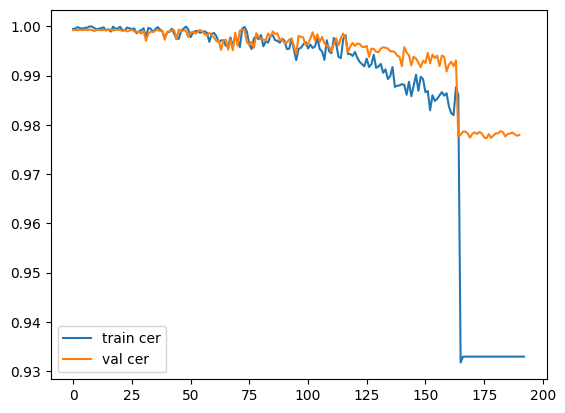

In [122]:
plt.plot(train_cer, label='train cer')
plt.plot(val_cer, label='val cer')
plt.legend()

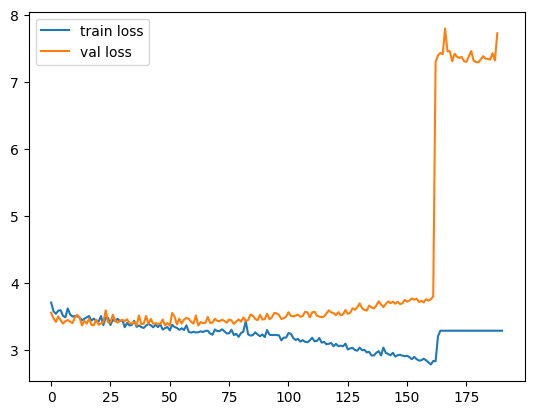

In [123]:
plt.plot([math.log(i) for i in train_loss[2:]], label='train loss')
plt.plot([math.log(i) for i in val_loss][2:], label='val loss')
plt.legend()

In [ ]:
torch.save(model, 'arina1903.torch')

In [116]:
model = torch.load('arina1903.torch')

In [118]:
model.to(device)

Model(
  (cnn): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(64, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=34, bias=True)
  (act): LogSoftmax(dim=-1)
)

Гипотеза: Сформировать батчи как набор индексов, запоминать лосс  на каждом батче. Подавать модели батч с наибольшим лоссоом.